# Test rectangular cutout using tesscut service interface

In [1]:
from __future__ import print_function
%matplotlib inline
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS

import numpy
import os
import pylab
import requests
from io import BytesIO
import zipfile
from pprint import pprint

## Functions to query astrocut services

See https://mastdev.stsci.edu/tesscut/ for a description of the services.

In [2]:
def sectors(ra, dec, radius=0, verbose=False,
           host="mastdev.stsci.edu", service="/tesscut/api/v0.1/sector"):
    """Return object with info on TESS sectors available for this position
    Inputs:
    ra, dec   Position [J2000 degrees]
    radius    Radius [arcmin]
    verbose   If true, prints additional info
    host, service describe the query
    
    Returns object with results
    """
    url = 'https://{host}{service}'.format(**locals())
    r = requests.get(url, params={'ra': ra, 'dec': dec, 'radius':'{}m'.format(radius)})
    if verbose:
        print(r.url)
    if r.status_code != 200:
        raise requests.ConnectionError("Status error {} for url {}".format(r.status_code, url))
    return r.json()


def getfitslist(ra, dec, size=11, sector=None, verbose=False,
           host="mastdev.stsci.edu", service="/tesscut/api/v0.1/astrocut",
           tesscut_token='682beebab024486984e03eb5dba9d879'):
    """Return list of fits objects with extracted TESS cutouts
    Inputs:
    ra, dec   Position [J2000 degrees]
    size      Cutout size [pixels]
              Size may also be a 2-element tuple with x,y sizes
    sector    Optional sector to select (default is to return all available sectors)
    verbose   If true, prints some additional info
    host, service describe the query
    
    Returns a list with zero or more fits objects extracted from the results
    """
    url = 'https://{host}{service}'.format(**locals())
    try:
        x = size[0]
        y = size[1]
    except TypeError:
        x = int(size)
        y = x
    params = {'ra': ra, 'dec': dec, 'x': x, 'y': y, 'units': 'px'}
    if sector:
        params['sector'] = sector
    headers = {'Authorization': "token {}".format(tesscut_token)}
    r = requests.get(url, params=params, headers=headers)
    if verbose:
        print(r.url)
    if r.status_code != 200:
        raise requests.ConnectionError("Status error {} for url {}".format(r.status_code, r.url))
    try:
        zfh = zipfile.ZipFile(BytesIO(r.content),'r')
    except zipfile.BadZipFile as e:
        rv = r.json()
        if 'msg' in rv:
            raise ValueError(rv['msg'])
        else:
            pprint(rv)
            raise e
    # open all the contained fits files
    # this is a bit of a pain: since we cannot seek on a compressed
    # zip file, we have to read the data, wrap it in another BytesIO object,
    # and then open that using fits.open
    if verbose:
        print("Got",len(zfh.namelist()),"FITS files in zip file")
    fitslist = []
    for name in zfh.namelist():
        if verbose:
            print(name)
        fhsub = BytesIO(zfh.open(name).read())
        fitslist.append(fits.open(fhsub))
        # preserve the original filename in the fits object
        fitslist[-1].filename = name
    return fitslist

## Read a cutout

Cutout is 20 x 10 pixels (in x, y)

In [4]:
# Gaia DR2 sourceid 5287565990802539776
# g = 11 mag
ra = 112.5224
dec = -64.9688
results = sectors(ra,dec)
print("ra dec {} {} is found in {} sector(s)".format(ra,dec,len(results['results'])))
pprint(results)

flist = getfitslist(ra,dec,size=(20,10))
print("ra dec {} {} got {} fits file(s)".format(ra,dec,len(flist)))
print([x.filename for x in flist])
fh  = flist[0]
print("Using first file:", fh.filename)
fh.info()

ra dec 112.5224 -64.9688 is found in 2 sector(s)
{'results': [{'camera': '4',
              'ccd': '3',
              'sector': '0001',
              'sectorName': 'tess-s0001-4-3'},
             {'camera': '4',
              'ccd': '3',
              'sector': '0002',
              'sectorName': 'tess-s0002-4-3'}]}
ra dec 112.5224 -64.9688 got 2 fits file(s)
['tess-s0001-4-3_112.5224_-64.9688_10x20_astrocut.fits', 'tess-s0002-4-3_112.5224_-64.9688_10x20_astrocut.fits']
Using first file: tess-s0001-4-3_112.5224_-64.9688_10x20_astrocut.fits
Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  PIXELS        1 BinTableHDU    244   1282R x 12C   [D, E, J, 200J, 200E, 200E, 200E, 200E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU       143   (10, 20)   float64   


## Extract data arrays and show the cumulative image

Two versions of the image are shown, one in the shape returned by tesscut and a second with the dimensions reversed to correct the bug.

flux shape (1282, 10, 20) tflux shape (10, 20)


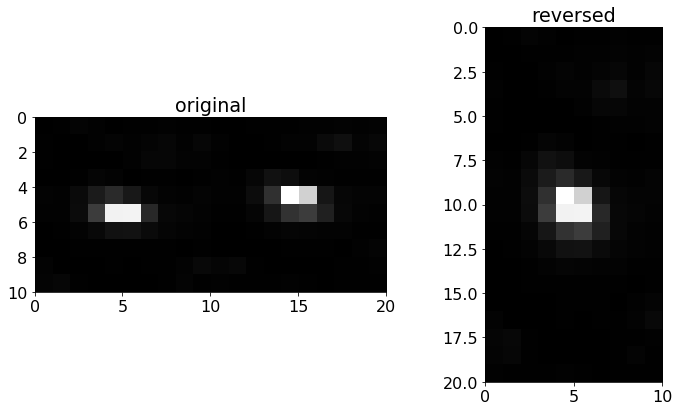

In [5]:
tab = Table(fh[1].data)
flux = tab['FLUX']
tflux = numpy.nanmean(flux,axis=0)
print('flux shape {} tflux shape {}'.format(flux.shape,tflux.shape))
# fix bug in image shape by reversing the image shape
tflux2 = tflux.reshape(tflux.shape[::-1])

pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(11,6))
pylab.subplot(121)
extent = (0,tflux.shape[1],tflux.shape[0],0)
pylab.imshow(tflux,cmap='gray',origin='upper',extent=extent)
pylab.title('original')

pylab.subplot(122)
extent2 = (0,tflux2.shape[1],tflux2.shape[0],0)
pylab.imshow(tflux2,cmap='gray',origin='upper',extent=extent2)
pylab.title('reversed')

pylab.tight_layout()
pylab.savefig('revshape.png')

## Look at table header

The TDIM4 and TDIM5 keywords are '(20,10)', but the actual dimensions of the arrays are '(10,20)'.  (20,10) matches the desired rectangular dimensions but not the actual shape of the data (which got swapped somewhere).

In [8]:
print(repr(fh[1].header))

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4066 / length of dimension 1                          
NAXIS2  =                 1282 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   12 / number of table fields                         
TTYPE1  = 'TIME    '           / column name                                    
TFORM1  = 'D       '           / column format                                  
TUNIT1  = 'BJD - 2457000, days' / unit                                          
TDISP1  = 'D14.7   '           / display format                                 
TTYPE2  = 'TIMECORR'        